In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB.Polypeptide import three_to_one as protein_letters_3to1

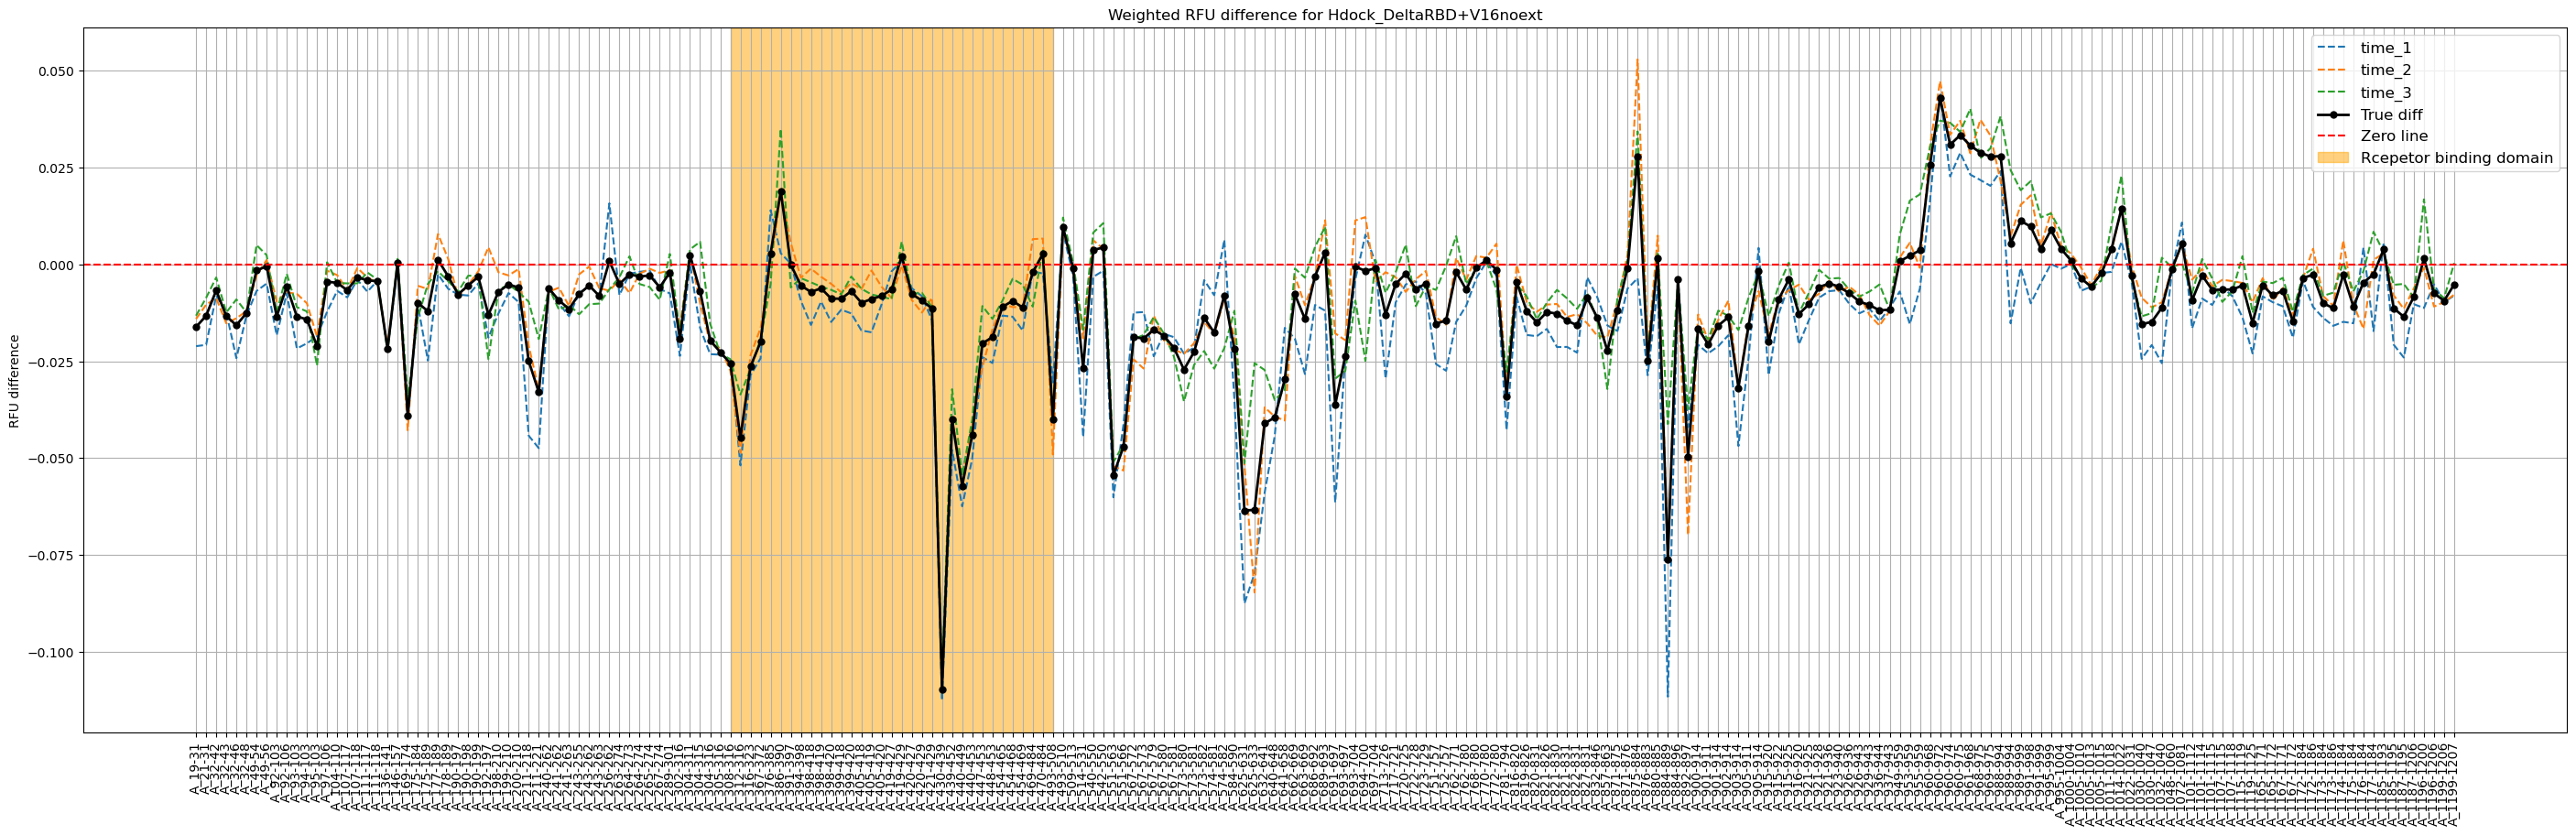

In [50]:
#intial setting
protein_name = 'Hdock_DeltaRBD+V16noext'
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/HDX_files/COVID_SPIKE.xlsx'
apo_states = [('Delta', 'apo', 'A')] #(protein, state, chain)
complex_states = [('Delta', 'VH16_VL104', 'A')]

fpath = f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/HDX_pred_{protein_name}.csv'
df = pd.read_csv(fpath)

# get time-weighted uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
def get_true_diff(HDX_fpath, apo_states, complex_states):
    def get_weighted_uptake(HDX_df, protein, state, chain):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])
        
        exposures = temp_HDX_df['log_t'].unique()
        unweighted_RFU = []
        for time in exposures:
            unweighted_RFU.append(temp_HDX_df[temp_HDX_df['log_t']==time]['%d'].to_numpy())
        unweighted_RFU = np.row_stack(unweighted_RFU)

        weighted_uptake = np.mean(unweighted_RFU, axis=0) / 100 # FIXME: percentage 

        temp_HDX_df = temp_HDX_df.drop_duplicates(subset=['sequence'], keep = 'last')
        start, end = temp_HDX_df['start'].to_numpy(), temp_HDX_df['end'].to_numpy()
        x_label = [f'{chain}_{start[i]}-{end[i]}' for i in range(len(start))]
        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo = {}
    apo_uptake, x_label = [], []
    apo_mtx = []

    for protein, state, letter in apo_states:
        uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, letter)
        apo_uptake.append(uptake)
        apo_mtx.append(U_apo_mtx)
        x_label += label
    apo_uptake = np.concatenate(apo_uptake)
    apo_mtx = np.concatenate(apo_mtx, axis =1)

    for i in range(len(x_label)):
        true_apo[x_label[i]] = apo_uptake[i]

    true_complex = {}
    complex_uptake, x_label = [], []
    complex_mtx = []

    for protein, state, letter in complex_states:
        uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, letter)
        complex_uptake.append(uptake)
        complex_mtx.append(U_complex_mtx)
        x_label += label
    complex_uptake = np.concatenate(complex_uptake)
    complex_mtx = np.concatenate(complex_mtx, axis =1)

    for i in range(len(x_label)):
        true_complex[x_label[i]] = complex_uptake[i]

    true_diff = {}
    diff_mtx = complex_mtx - apo_mtx
    for key in true_apo.keys():
        true_diff[key] = true_complex[key] - true_apo[key]
    return true_diff, diff_mtx

# Delta true diff 
true_diff, diff_RFU_mtx = get_true_diff(HDX_fpath, apo_states, complex_states)

#plot weighted truth
plt.figure(figsize=(35, 10))
plt.xticks(np.arange(0, len(true_diff.keys()), 1), list(true_diff.keys()), rotation=90)
for i in range(diff_RFU_mtx.shape[0]):
    plt.plot(diff_RFU_mtx[i, :]/100, label=f'time_{i+1}', linestyle = '--', alpha= 1)
plt.plot(list(true_diff.keys()) ,list(true_diff.values()), label='True diff', color = 'k', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.ylabel('RFU difference')
plt.title(f'Weighted RFU difference for {protein_name}')
plt.axhline(y=0, color='r', linestyle='--', label='Zero line')
plt.axvspan(53, 85, color='orange',label = 'Rcepetor binding domain', alpha=0.5)
plt.grid(True)
plt.legend(fontsize='large')
plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_weightedTruth.png',  dpi=300)

Top 10 models:
model_39 , 0.765176298497108
model_53 , 0.7753785693683061
model_11 , 0.8129930391886234
model_18 , 0.8222751918009098
model_84 , 0.8440391327377738
model_3 , 0.8447209953599172
model_77 , 0.8463728392291994
model_70 , 0.8471800674383053
model_38 , 0.849988862772124
model_36 , 0.8538970580666615


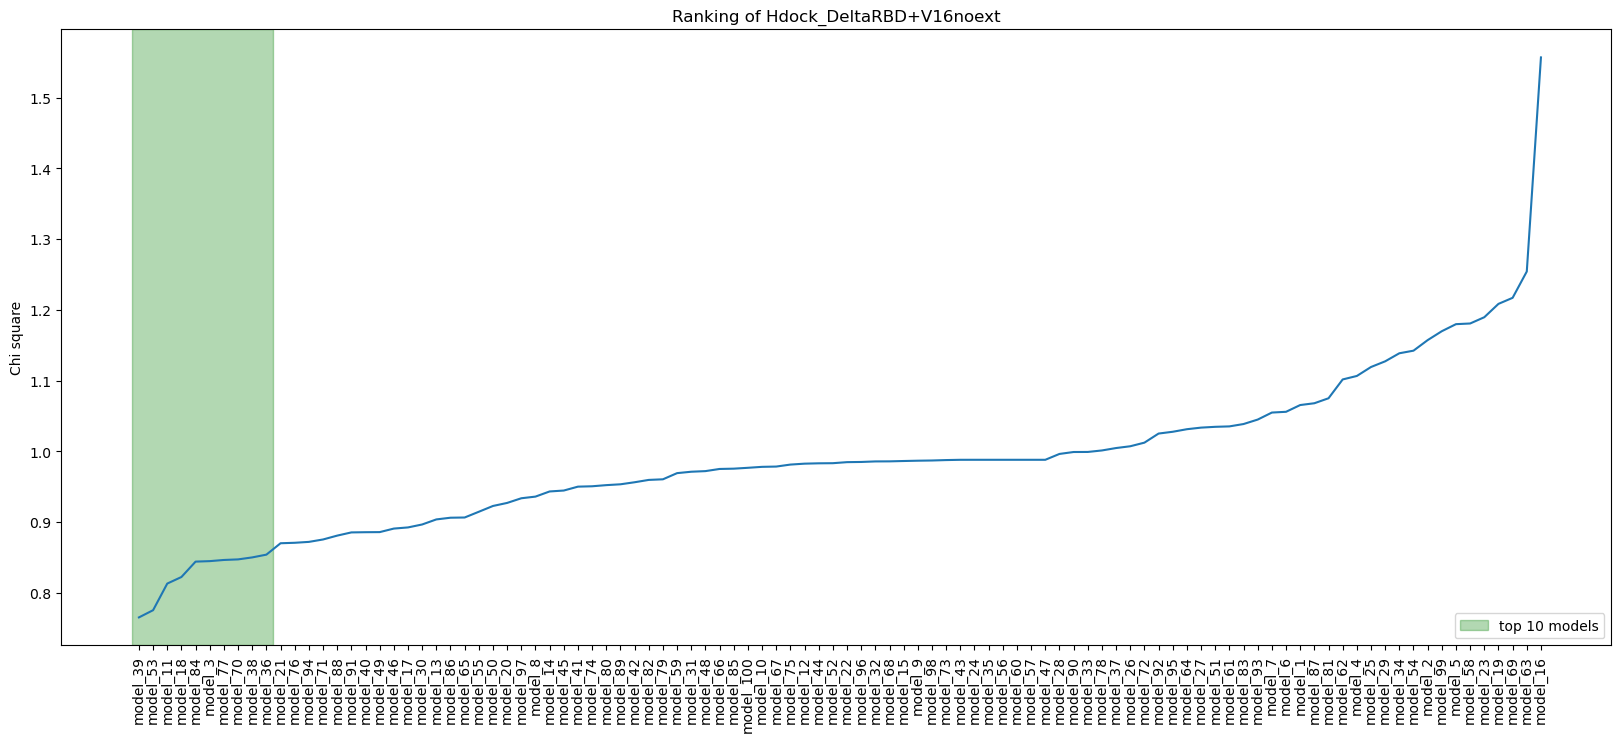

In [48]:
# calculate mse and rank models
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip predictions to avoid log(0)
    bce = -np.sum(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred)) / y_true.shape[0]
    return bce
def mean_squared_error(y_true, y_pred, error_limit):
    return np.mean(((y_true - y_pred)/error_limit) ** 2)

def get_mae(df, batch_name, true_diff):
    complex_true_df = df[df['Batch'] == batch_name]
    pred_dict = {}
    pred_diff = {}
    for i, row in complex_true_df.iterrows():
        pred_dict[row['Range']] = row['Y_Pred']

    complex_baseline = df[df['Batch'] == 'finetune'] 

    for i, row in complex_baseline.iterrows(): # FIXME: only for chain A 
        range_label = row['Range']
        revised_label = 'A' + range_label[1:]
        if revised_label in pred_dict:
            pred_diff[range_label] = pred_dict[revised_label] - row['Y_Pred']
        

    trim_true_diff = {}
    for key in true_diff.keys():
        if key in pred_diff.keys():
            trim_true_diff[key] = true_diff[key]
    x_labels = list(trim_true_diff.keys())
    x_index = np.arange(len(x_labels))
    y_true = np.array(list(trim_true_diff.values()))
    y_pred = np.array([pred_diff[key] for key in x_labels])

    #transformation
    #y_true = sigmoid(y_true)
    #y_pred = sigmoid(y_pred)
    #loss = binary_cross_entropy(y_true, y_pred)
    error_limit = 0.025
    loss = mean_squared_error(y_true, y_pred, error_limit)
    return loss

# you should get true_diff from previous cell
batches = [f'{protein_name}_{i}_revised' for i in range(1, 101)]
model_name = [f'model_{i}' for i in range(1, 101)]
maes = []
for batch in batches:
    mae = get_mae(df, batch, true_diff)
    maes.append(mae)

sorted_batch = sorted(zip(batches, maes, model_name), key=lambda x: x[1])

print('Top 10 models:')
for rank in sorted_batch[:10]:
    print(rank[2], ',', rank[1])
x_index = np.arange(len(batches))

plt.figure(figsize = (20, 8))
plt.xticks(x_index, [i[2] for i in sorted_batch], rotation=90)
plt.axvspan(-0.5, 9.5, color='green', label = 'top 10 models', alpha=0.3)
plt.plot([i[1] for i in sorted_batch])
plt.ylabel('Chi square')
plt.title(f'Ranking of {protein_name}')
plt.legend()
plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_ranking.png', dpi=300)

In [30]:
## extract binding site functions
from collections import defaultdict
import os
from scipy.spatial.distance import cdist
from Bio import PDB
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns

class Chain:
    def __init__(self):
        self.atoms = []
        self.sequence_type = None

    def add_atom(self, atom_index, residue_index, residue_type, atom_type, coordinates):
        atom_info = {
            'atom_index': atom_index,
            'residue_index': residue_index,
            'residue_type': residue_type,
            'atom_type': atom_type,
            'coordinates': coordinates
        }
        self.atoms.append(atom_info)

    def get_atoms(self):
        return self.atoms
    
    def get_residues(self):
        # group atoms by residue
        atoms = self.get_atoms()
        key = lambda x: x['residue_index']
        #atoms = sorted(atoms, key=key)
        residues = [list(group) for key, group in groupby(atoms, key)]
        return residues

def read_PDB(key, PDB_path):
    if not os.path.isfile(PDB_path):
        print("cannot find the file", key)
        return None
    chains = defaultdict(Chain)

    with open(PDB_path, 'r') as f:
        data = f.read().strip().split('\n') 
        for line in data:
            if line[:4] == 'ATOM':
                n_res = int(line[23:26].strip())
                n_atom = int(line[6:11].strip())
                res_type = line[17:20].strip()
                atom_type = line[12:16].strip()
                chain = line[21].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                chain_id = line[21].strip()
                if atom_type == 'CA':
                    chains[chain_id].add_atom(n_atom, n_res, res_type, atom_type, [x, y, z])
    return chains

def bindingsite_extract(chains, chain1 = 'A', chain2 = 'B', dist_cutoff=3.65): ###assume only two chains in the PDB file
    chainA = chains[chain1]
    chainB = chains[chain2]
    coords_a = [atom['coordinates'] for atom in chainA.get_atoms()]
    coords_b = [atom['coordinates'] for atom in chainB.get_atoms()]

    coords_array_a = np.array(coords_a)
    coords_array_b = np.array(coords_b)
    dist_matrix = cdist(coords_array_a, coords_array_b, 'euclidean')

    pairs = dist_criterion(dist_matrix, cutoff=dist_cutoff) # different criterion can be used here
    contact_list = []
    for pair in pairs:
        resA_id = pair[0]
        resB_id = pair[1]

        resA = chainA.get_atoms()[resA_id]['residue_index']
        resB = chainB.get_atoms()[resB_id]['residue_index']
        contact_list.append((resA, resB))
    contact_list = np.array(contact_list)
    if contact_list.shape[0] == 0:
        return None, None
    
    max_res_A = max([res['residue_index'] for res in chainA.get_atoms()])
    max_res_B = max([res['residue_index'] for res in chainB.get_atoms()])
    contact_resmap = np.zeros((max_res_A, max_res_B))
    contact_resmap[contact_list[:, 0]-1, contact_list[:, 1]-1] = 1

    return contact_resmap, contact_list

def dist_criterion(dist_matrix, cutoff):
    dist_matrix = np.array(dist_matrix)
    mask = dist_matrix < cutoff
    indices = np.where(mask)
    pairs = list(zip(indices[0], indices[1]))
    return pairs

Hdock_DeltaRBD+V16noext_39_revised.pdb
Hdock_DeltaRBD+V16noext_53_revised.pdb
Hdock_DeltaRBD+V16noext_11_revised.pdb
Hdock_DeltaRBD+V16noext_18_revised.pdb
Hdock_DeltaRBD+V16noext_84_revised.pdb
Hdock_DeltaRBD+V16noext_3_revised.pdb
Hdock_DeltaRBD+V16noext_77_revised.pdb
Hdock_DeltaRBD+V16noext_70_revised.pdb
Hdock_DeltaRBD+V16noext_38_revised.pdb
Hdock_DeltaRBD+V16noext_36_revised.pdb
dict_keys([('A', 'D'), ('A', 'E'), ('C', 'E'), ('C', 'D')])
445 56 0.3


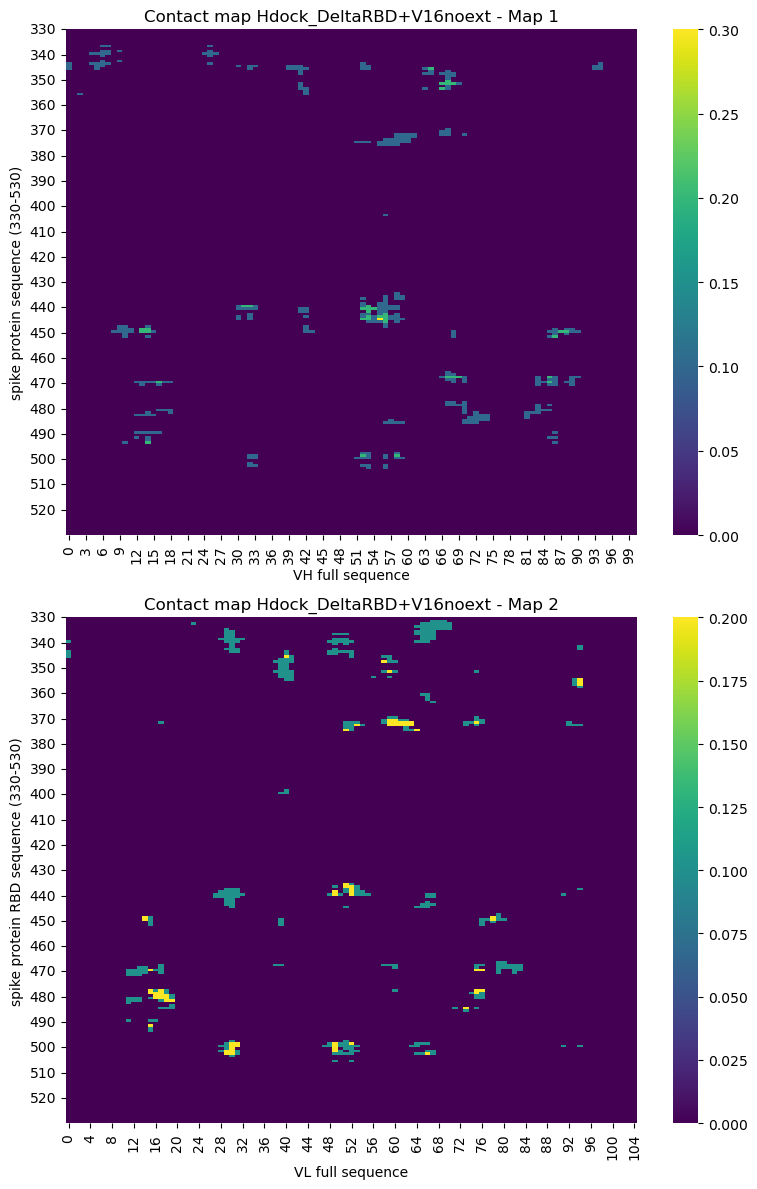

In [49]:
id_list = [39, 53, 11, 18,84, 3, 77,70, 38, 36]
pdb_list = [f'{protein_name}_{i}_revised.pdb' for i in id_list]
dist_cutoff =  10 # Angstrom

rec_chain = ['A', 'C']
lig_chain = ['D', 'E']
map_dict = {}
for pdb in pdb_list:
    print(pdb)
    pdb_fpath = f'/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/hdock/{protein_name}/{pdb}'
    chains = read_PDB('model1', pdb_fpath)
    for rec in rec_chain:
        for lig in lig_chain:
            contact_, contact_list = bindingsite_extract(chains, chain1=rec, chain2=lig, dist_cutoff=dist_cutoff)
            if contact_list is None:
                continue
            if (rec, lig) not in map_dict.keys():
                map_dict[(rec, lig)] = []
            map_dict[(rec, lig)].extend(list(contact_list))

print(map_dict.keys())
D_contact = map_dict[('A', 'D')] + map_dict[('C', 'D')]
E_contact = map_dict[('C', 'E')] + map_dict[('A', 'E')]

D_res_map = np.zeros((999, 101))
E_res_map = np.zeros((999, 105))

for pos in D_contact:
    D_res_map[pos[0]-1, pos[1]-1] += 1
for pos in E_contact:
    E_res_map[pos[0]-1, pos[1]-1] += 1

D_res_map = D_res_map / len(id_list)
E_res_map = E_res_map / len(id_list)
def plot_resmap(res_map1, res_map2):
    fig, axs = plt.subplots(2, 1, figsize=(8,12))  # create a figure with two subplots arranged vertically

    # plot the first heatmap
    sns.heatmap(res_map1, cmap='viridis', ax=axs[0])
    axs[0].set_xlabel('VH full sequence')
    axs[0].set_ylabel(f'spike protein sequence ({start}-{end})')
    axs[0].set_title(f'Contact map {protein_name} - Map 1')
    axs[0].set_yticks(np.arange(0, res_map1.shape[0], 10))
    axs[0].set_yticklabels(np.arange(start, end, 10))
    #axs[0].axvline(x=101, color='red', linestyle='--')

    # plot the second heatmap
    sns.heatmap(res_map2, cmap='viridis', ax=axs[1])
    axs[1].set_xlabel('VL full sequence')
    axs[1].set_ylabel(f'spike protein RBD sequence ({start}-{end})')
    axs[1].set_title(f'Contact map {protein_name} - Map 2')
    axs[1].set_yticks(np.arange(0, res_map2.shape[0], 10))
    axs[1].set_yticklabels(np.arange(start, end, 10))

    plt.tight_layout()  # adjust the layout so that the plots do not overlap
    plt.savefig(f'/home/lwang/models/HDX_LSTM/results/240411_BiLSTMGAT_v2_1/{protein_name}_resmap.png')

#plot_resmap(D_res_map, E_res_map)
start = 330
end = 530
plot_resmap(D_res_map[start:end, :], E_res_map[start:end, :])


# print out [i, j] in D_res_map if the value is larger than 0.2
for i in range(D_res_map.shape[0]):
    for j in range(D_res_map.shape[1]):
        if D_res_map[i, j] > 0.2:
            print(i+1, j+1, D_res_map[i, j])

In [6]:
import pandas as pd
import numpy as np  # For numerical operations

# Load the dataset
fpath = '/home/lwang/models/S3214dataset/HDX_pred_myoglobin.csv'
df = pd.read_csv(fpath)
print(df.head())

# Initialize data dictionary
data = {}

# Extract baseline data
baseline = df[df['Batch'] == '1bz6A_relaxed']
baseline_dict = {row['Range']: row['Y_Pred'] for _, row in baseline.iterrows()}

# Populate data dictionary with batch and range information
for _, row in df.iterrows():
    batch = row['Batch']
    range_value = row['Range']  # Assume Range is a hashable type like a string or number
    if batch not in data:
        data[batch] = {}
    data[batch].setdefault(range_value, []).append(row['Y_Pred'])
print(data)

# Compare each batch's prediction to the baseline and print differences
HDX_diff = {}
for batch_key, ranges in data.items():
    diff_list = []
    for range_key, values in ranges.items():
        if range_key in baseline_dict:
            mean_values = np.mean(values)  # Calculate the mean of predictions
            difference = mean_values - baseline_dict[range_key]
            diff_list.append(difference)
    diff_sum = np.sum(diff_list)
    [batch_key] = difHDX_difff_sum


           Batch  Y_True    Y_Pred Chain      Range
0  1bz6A_relaxed     0.0  0.109340     A  A_129-144
1  1bz6A_relaxed     0.0  0.178416     A    A_38-53
2  1bz6A_relaxed     0.0  0.094754     A   A_98-113
3  1bz6A_relaxed     0.0  0.177849     A  A_124-139
4  1bz6A_relaxed     0.0  0.226996     A    A_73-88
{'1bz6A_relaxed': {'A_129-144': [0.1093402877449989], 'A_38-53': [0.1784159541130066], 'A_98-113': [0.0947543829679489], 'A_124-139': [0.1778488308191299], 'A_73-88': [0.2269959449768066], 'A_84-99': [0.2038565278053283], 'A_51-66': [0.1425412148237228], 'A_34-49': [0.2005913108587265], 'A_136-151': [0.1334924697875976], 'A_2-17': [0.2851278185844421], 'A_102-117': [0.0933979451656341], 'A_83-98': [0.2440451830625534], 'A_35-50': [0.1627707481384277], 'A_21-36': [0.1826433986425399], 'A_94-109': [0.1197566166520118], 'A_10-25': [0.2933603227138519], 'A_26-41': [0.1751710325479507], 'A_1-16': [0.1799401342868805], 'A_92-107': [0.1039158105850219], 'A_49-64': [0.1628742516040802], 

In [14]:
print(HDX_diff.keys())

dict_keys(['1bz6A_relaxed', '1bz6A_T67A_relaxed', '1bz6A_L135A_relaxed', '1bz6A_L69A_relaxed', '1bz6A_V68Y_relaxed', '1bz6A_L29A_relaxed', '1bz6A_H64R_relaxed', '1bz6A_F106A_relaxed', '1bz6A_V68F_relaxed', '1bz6A_K133A_relaxed', '1bz6A_T51A_relaxed', '1bz6A_G23A_relaxed', '1bz6A_F123A_relaxed', '1bz6A_I30A_relaxed', '1bz6A_E109A_relaxed', '1bz6A_I107A_relaxed', '1bz6A_R118A_relaxed', '1bz6A_L135M_relaxed', '1bz6A_H64W_relaxed', '1bz6A_L69M_relaxed', '1bz6A_H97Q_relaxed', '1bz6A_E18A_relaxed', '1bz6A_H64A_relaxed', '1bz6A_G129A_relaxed', '1bz6A_H82Q_relaxed', '1bz6A_H113Q_relaxed', '1bz6A_L29M_relaxed', '1bz6A_L9A_relaxed', '1bz6A_L29N_relaxed', '1bz6A_V68I_relaxed', '1bz6A_F123T_relaxed', '1bz6A_W14F_relaxed', '1bz6A_F123K_relaxed', '1bz6A_I107T_relaxed', '1bz6A_H64T_relaxed', '1bz6A_A130K_relaxed', '1bz6A_T67Q_relaxed', '1bz6A_L32F_relaxed', '1bz6A_I28A_relaxed', '1bz6A_A144L_relaxed', '1bz6A_K77A_relaxed', '1bz6A_V66A_relaxed', '1bz6A_I142L_relaxed', '1bz6A_L149A_relaxed', '1bz6A_E10

  protein  mut_pos pre_res post_res  deltaG
0   1bz6A       28       I        A    2.06
1   1bz6A       29       L        A    0.39
2   1bz6A       30       I        A    1.90
3   1bz6A       32       L        A    2.04
4   1bz6A       24       H        V    0.52
(134, 5)
{'1bz6A_I28A_relaxed': 0.53, '1bz6A_L29A_relaxed': 2.37, '1bz6A_I30A_relaxed': 1.9, '1bz6A_L32A_relaxed': 0.47, '1bz6A_H24V_relaxed': 0.52, '1bz6A_H36Q_relaxed': 0.8, '1bz6A_H48Q_relaxed': 0.62, '1bz6A_H64Q_relaxed': -0.02, '1bz6A_H82Q_relaxed': 0.05, '1bz6A_H93G_relaxed': -0.04, '1bz6A_H97Q_relaxed': 0.11, '1bz6A_H113Q_relaxed': 0.26, '1bz6A_H119F_relaxed': 0.68, '1bz6A_G129A_relaxed': -1.05, '1bz6A_V66A_relaxed': -0.75, '1bz6A_P88A_relaxed': -0.59, '1bz6A_H116A_relaxed': -0.16, '1bz6A_V13A_relaxed': 0.0, '1bz6A_T67A_relaxed': 0.26, '1bz6A_S117A_relaxed': 0.26, '1bz6A_L11A_relaxed': 0.6, '1bz6A_L9A_relaxed': 0.41, '1bz6A_G23A_relaxed': 1.12, '1bz6A_L137A_relaxed': 0.3, '1bz6A_V114A_relaxed': 1.45, '1bz6A_T51A_relaxed

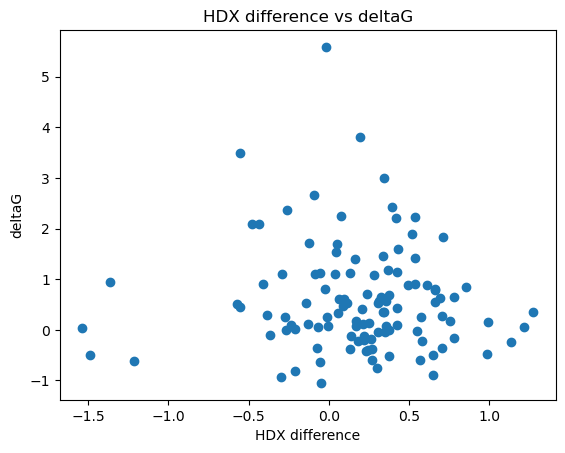

In [18]:
import matplotlib.pyplot as plt

fpath = '/home/lwang/models/S3214dataset/datasets/myoglobin.txt'
myo_G = pd.read_csv(fpath, sep = ' ', header=None)
myo_G.columns = ['protein', 'mut_pos', 'pre_res', 'post_res', 'deltaG']
print(myo_G.head())
print(myo_G.shape)

deltaG = {}
for index, row in myo_G.iterrows():
    protein =row["protein"]
    pre_res = row["pre_res"]
    mut_pos = row["mut_pos"]
    post_res = row["post_res"]

    batch_label = f'{protein}_{pre_res}{mut_pos}{post_res}_relaxed'
    deltaG[batch_label] = row['deltaG']

print(deltaG)

X_data = []
Y_data = []
for key in deltaG.keys():
    if key in HDX_diff.keys():
        X_data.append(HDX_diff[key])
        Y_data.append(deltaG[key])

plt.figure()
plt.scatter(X_data, Y_data)
plt.xlabel('HDX difference')
plt.ylabel('deltaG')
plt.title('HDX difference vs deltaG')
plt.show()
